In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def local_window_mask(seq_len, window_size):
    mask = torch.zeros(seq_len, seq_len)

    for i in range(seq_len):
        start = max(0, i - window_size)
        end = min(seq_len, i + window_size + 1)
        mask[i, start:end] = 1

    return mask

In [3]:
def block_sparse_mask(seq_len, block_size):
    mask = torch.zeros(seq_len, seq_len)

    for i in range(0, seq_len, block_size):
        mask[i:i+block_size, i:i+block_size] = 1

    return mask

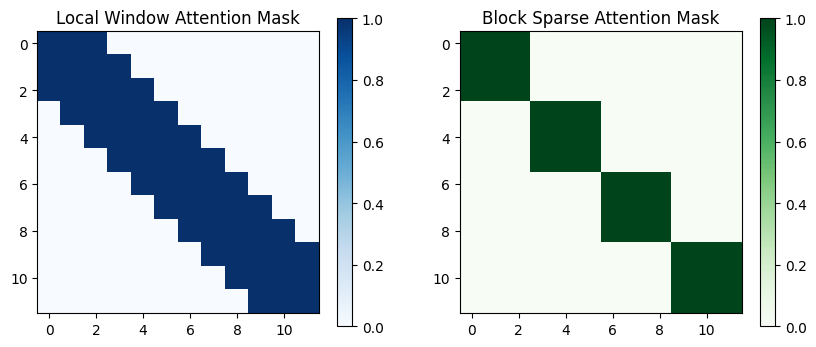

In [4]:
seq_len = 12

window_mask = local_window_mask(seq_len, window_size=2)
block_mask = block_sparse_mask(seq_len, block_size=3)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(window_mask, cmap='Blues')
plt.title("Local Window Attention Mask")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(block_mask, cmap='Greens')
plt.title("Block Sparse Attention Mask")
plt.colorbar()

plt.show()

In [6]:
class SparseSelfAttention(nn.Module):
    def __init__(self, embed_dim, attention_mask):
        super().__init__()
        self.embed_dim = embed_dim
        self.attention_mask = attention_mask  # (seq_len, seq_len)

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.embed_dim ** 0.5)

        # apply mask: turn disallowed connections to -inf
        mask = self.attention_mask.unsqueeze(0)  # add batch dimension
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return output, attn_weights

In [7]:
embed_dim = 8
seq_len = 12

x = torch.randn(1, seq_len, embed_dim)

mask = local_window_mask(seq_len, window_size=2)
sparse_attn = SparseSelfAttention(embed_dim, mask)

output, weights = sparse_attn(x)
weights.shape

torch.Size([1, 12, 12])

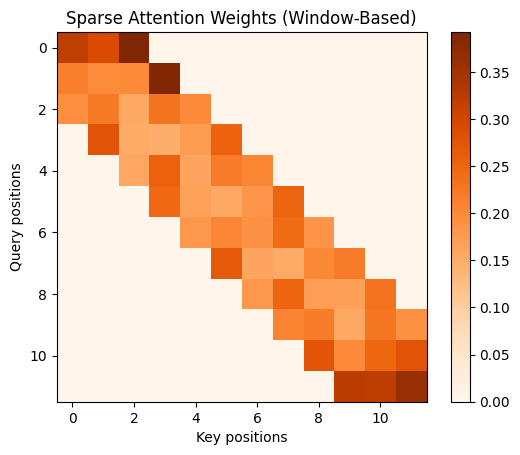

In [8]:
plt.imshow(weights[0].detach(), cmap='Oranges')
plt.title("Sparse Attention Weights (Window-Based)")
plt.colorbar()
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.show()